In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.integrate import trapezoid

In [2]:
# -------------------------------
# 1. Load IMU & Force Sensor Data
# -------------------------------
def load_imu_data(file_path):
    data = pd.read_csv(file_path)
    data["Time(s)"] = data["Time(ms)"] / 1000.0  # Convert time to seconds
    return data

def load_force_data(file_path):
    data = pd.read_csv(file_path)
    data["Time(s)"] = data["Time(ms)"] / 1000.0
    return data

# -------------------------------
# 2. Sensor Mapping
# -------------------------------
# SENSOR_MAPPING = {
#     "1": "LT",  # Left Thigh
#     "2": "RT",  # Right Thigh
#     "3": "LS",  # Left Shank
#     "4": "RS",  # Right Shank
#     "5": "LA",  # Left Ankle
#     "6": "RA"   # Right Ankle
# }

# -------------------------------
# 3. Apply Filters (Butterworth Low-Pass & High-Pass)
# -------------------------------
def butter_lowpass_filter(data, cutoff=5, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def high_pass_filter(data, cutoff=0.1, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

# -------------------------------
# 4. Detect Heel Strikes & Toe-Offs from Force Sensors
# -------------------------------
# Function to detect gait events (Heel Strikes and Toe-Offs)
def detect_gait_events(force_data, heel_threshold=1500, toe_threshold=-500):
    # Heel Strike Detection: Find peaks where force is greater than threshold
    peaks, _ = find_peaks(force_data["ForceValue"], height=heel_threshold, distance=100)  # distance ensures minimum separation between peaks

    # Toe-Off Detection: Look for large negative differences in force
    force_diff = force_data["ForceValue"].diff()
    valleys = force_diff[force_diff < toe_threshold].dropna().index  # Detect sharp drops in force
    
    return force_data["Time(s)"].iloc[peaks], force_data["Time(s)"].iloc[valleys]

# -------------------------------
# 5. Compute Joint Angles (Knee, Ankle)
# -------------------------------
def integrate_gyro(gyro_data, time, initial_angle=0):
    angle = np.cumsum(gyro_data * np.gradient(time))  # Numerical Integration
    return angle - np.mean(angle[:50]) + initial_angle  # Drift Correction

# -------------------------------
# 6. Compute Temporal Gait Parameters
# -------------------------------
def compute_temporal_parameters(heel_strikes):
    step_times = np.diff(heel_strikes)  # Time between heel strikes
    stride_times = step_times[::2]  # Stride time is every two steps
    cadence = 60 / np.mean(step_times)  # Steps per minute
    step_time_variability = np.std(step_times)  # Step variability
    return step_times, stride_times, cadence, step_time_variability

# -------------------------------
# 7. Compute Step Length & Gait Speed
# -------------------------------
def compute_step_length(accelY, time):
    velocity = np.cumsum(accelY * np.gradient(time))  # Integrate acceleration
    step_length = trapezoid(velocity, time) / len(time)  # Approximate distance per step
    return step_length

# -------------------------------
# 8. Compute Gait Symmetry
# -------------------------------
def compute_gait_symmetry(left_steps, right_steps):
    step_time_diff = np.abs(np.mean(left_steps) - np.mean(right_steps))
    stride_symmetry_index = (step_time_diff / (np.mean(left_steps) + np.mean(right_steps))) * 100
    return step_time_diff, stride_symmetry_index

In [3]:
# -------------------------------
# 9. Load Data and Perform Analysis
# -------------------------------
left_thigh_file = "../dataset_formatted_13-3-2025_Specimen_1/IMU/test1/LT.csv"
left_shank_file = "../dataset_formatted_13-3-2025_Specimen_1/IMU/test1/LS.csv"
left_ankle_file = "../dataset_formatted_13-3-2025_Specimen_1/IMU/test1/LA.csv"
right_thigh_file = "../dataset_formatted_13-3-2025_Specimen_1/IMU/test1/RT.csv"
right_shank_file = "../dataset_formatted_13-3-2025_Specimen_1/IMU/test1/RS.csv"
right_ankle_file = "../dataset_formatted_13-3-2025_Specimen_1/IMU/test1/RA.csv"
left_force_file = "../Test_13-3-2025/Specimen_1/Left_Force/test1.csv"
right_force_file = "../Test_13-3-2025/Specimen_1/Right_Force/test1.csv"

# imu_data = load_imu_data(imu_file)
left_thigh_data = load_imu_data(left_thigh_file)
left_shank_data = load_imu_data(left_shank_file)
left_ankle_data = load_imu_data(left_ankle_file)
right_thigh_data = load_imu_data(right_thigh_file)
right_shank_data = load_imu_data(right_shank_file)
right_ankle_data = load_imu_data(right_ankle_file)
left_force_data = load_force_data(left_force_file)
right_force_data = load_force_data(right_force_file)


In [4]:
fs = 100  

# Apply filtering
# imu_data["GyroZ_filtered"] = butter_lowpass_filter(imu_data["GyroZ"])
# imu_data["GyroZ_filtered"] = high_pass_filter(imu_data["GyroZ_filtered"], fs=fs)
fs = 100  

# Apply filtering
for data in [left_thigh_data, left_shank_data, left_ankle_data, right_thigh_data, right_shank_data, right_ankle_data]:
    data["GyroZ_filtered"] = butter_lowpass_filter(data["GyroZ"])
    data["GyroZ_filtered"] = high_pass_filter(data["GyroZ_filtered"], fs=fs)
    data["AccelY_filtered"] = butter_lowpass_filter(data["AccelY"])
    data["AccelY_filtered"] = high_pass_filter(data["AccelY_filtered"], fs=fs)
    data["GyroX_filtered"] = butter_lowpass_filter(data["GyroX"])
    data["GyroX_filtered"] = high_pass_filter(data["GyroX_filtered"], fs=fs)
    data["GyroY_filtered"] = butter_lowpass_filter(data["GyroY"])
    data["GyroY_filtered"] = high_pass_filter(data["GyroY_filtered"], fs=fs)

In [5]:
# # Extract Sensor-Specific Data
# left_thigh = imu_data[imu_data["SensorID"] == 1]
# left_shank = imu_data[imu_data["SensorID"] == 3]
# left_ankle = imu_data[imu_data["SensorID"] == 5]
# right_thigh = imu_data[imu_data["SensorID"] == 2]
# right_shank = imu_data[imu_data["SensorID"] == 4]
# right_ankle = imu_data[imu_data["SensorID"] == 6]

In [6]:
# Compute Joint Angles
left_knee_angle = integrate_gyro(left_shank_data["GyroZ_filtered"], left_shank_data["Time(s)"]) - integrate_gyro(left_thigh_data["GyroZ_filtered"], left_thigh_data["Time(s)"])
right_knee_angle = integrate_gyro(right_thigh_data["GyroZ_filtered"], right_thigh_data["Time(s)"]) - integrate_gyro(right_shank_data["GyroZ_filtered"], right_shank_data["Time(s)"])


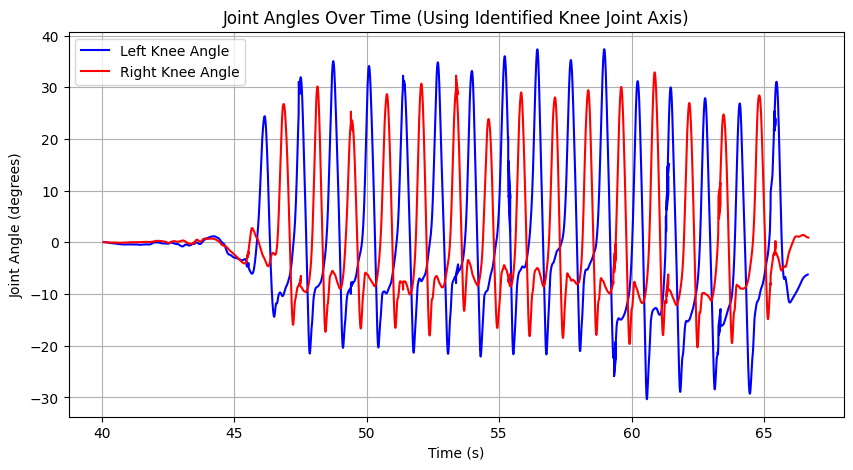

In [7]:
# -------------------------------
# 7. Plot Results
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(left_shank_data["Time(s)"], left_knee_angle, label="Left Knee Angle", color='b')
plt.plot(right_shank_data["Time(s)"], right_knee_angle, label="Right Knee Angle", color='r')
plt.xlabel("Time (s)")
plt.ylabel("Joint Angle (degrees)")
plt.legend()
plt.grid()
plt.title("Joint Angles Over Time (Using Identified Knee Joint Axis)")
plt.show()

In [55]:
# Detect Gait Events
left_heel_strikes, left_toe_offs = detect_gait_events(left_force_data, heel_threshold=2850, toe_threshold=-170)
right_heel_strikes, right_toe_offs = detect_gait_events(right_force_data, heel_threshold=2400, toe_threshold=-185)

# Compute Gait Parameters
left_step_times, left_stride_times, left_cadence, left_variability = compute_temporal_parameters(left_heel_strikes)
right_step_times, right_stride_times, right_cadence, right_variability = compute_temporal_parameters(right_heel_strikes)

# Compute Gait Symmetry
step_time_diff, stride_symmetry_index = compute_gait_symmetry(left_step_times, right_step_times)


In [56]:
print("Left Heel Strikes:", len(left_heel_strikes))
print("Right Heel Strikes:", len(right_heel_strikes))
print("Left Cadence:", left_cadence)
print("Right Cadence:", right_cadence)
print("Step Time Difference:", step_time_diff)
print("Stride Symmetry Index:", stride_symmetry_index)
print("Left Variability:", left_variability)
print("Right Variability:", right_variability)
print("Left Step Length:", compute_step_length(left_ankle_data["AccelY"], left_ankle_data["Time(s)"]))
print("Right Step Length:", compute_step_length(right_ankle_data["AccelY"], right_ankle_data["Time(s)"]))
print("Left Toe Offs:", len(left_toe_offs))
print("Right Toe Offs:", len(right_toe_offs))

Left Heel Strikes: 20
Right Heel Strikes: 20
Left Cadence: 68.69952995058458
Right Cadence: 62.67179769103901
Step Time Difference: 0.08400000000000063
Stride Symmetry Index: 4.588316467341341
Left Variability: 0.5262507117661217
Right Variability: 0.5096122582313073
Left Step Length: 0.007066765670126391
Right Step Length: -0.0018290301112280248
Left Toe Offs: 20
Right Toe Offs: 19


In [57]:
# -------------------------------
# Print Summary Results
# -------------------------------
print(f"Left Cadence: {left_cadence:.2f} steps/min")
print(f"Right Cadence: {right_cadence:.2f} steps/min")
print(f"Step Time Difference: {step_time_diff:.2f} s")
print(f"Stride Symmetry Index: {stride_symmetry_index:.2f}%")

Left Cadence: 68.70 steps/min
Right Cadence: 62.67 steps/min
Step Time Difference: 0.08 s
Stride Symmetry Index: 4.59%


In [11]:
print(f"Shape of left_shank['Time(s)']: {left_shank_data['Time(s)'].shape}")
print(f"Shape of left_knee_angle: {left_knee_angle.shape}")

print(f"Shape of right_thigh['Time(s)']: {right_thigh_data['Time(s)'].shape}")
print(f"Shape of right_knee_angle: {right_knee_angle.shape}")


Shape of left_shank['Time(s)']: (6655,)
Shape of left_knee_angle: (6655,)
Shape of right_thigh['Time(s)']: (6647,)
Shape of right_knee_angle: (6650,)


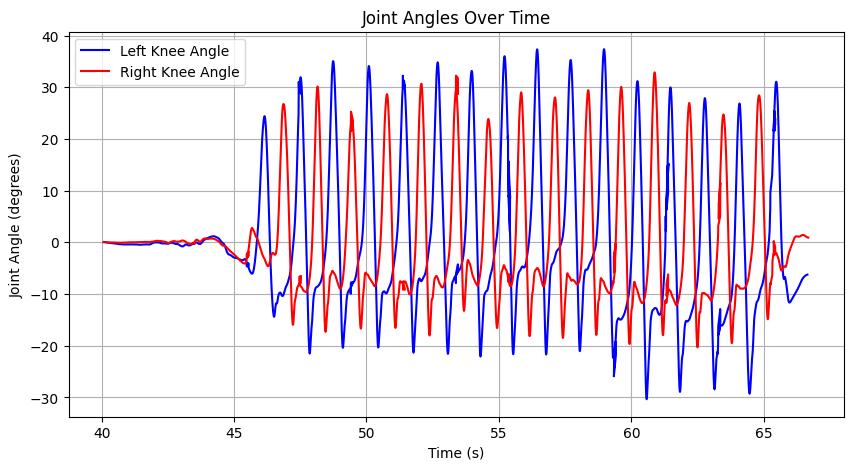

In [58]:
# -------------------------------
# Plot Results
# -------------------------------
min_length_left = min(len(left_shank_data["Time(s)"]), len(left_knee_angle))
min_length_right = min(len(right_thigh_data["Time(s)"]), len(right_knee_angle))

plt.figure(figsize=(10, 5))
plt.plot(left_shank_data["Time(s)"].iloc[:min_length_left], left_knee_angle[:min_length_left], label="Left Knee Angle", color='b')
plt.plot(right_thigh_data["Time(s)"].iloc[:min_length_right], right_knee_angle[:min_length_right], label="Right Knee Angle", color='r')

plt.xlabel("Time (s)")
plt.ylabel("Joint Angle (degrees)")
plt.legend()
plt.grid()
plt.title("Joint Angles Over Time")
plt.show()

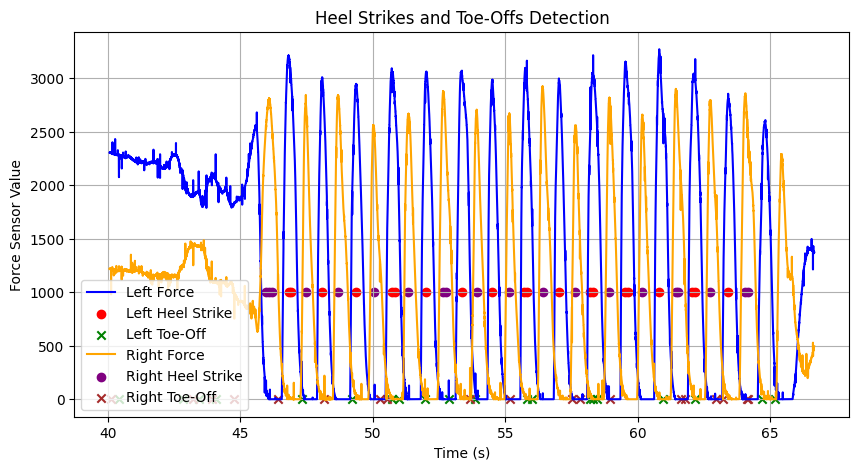

In [59]:
# -------------------------------
# Plot Heel Strikes & Toe-Offs
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(left_force_data["Time(s)"], left_force_data["ForceValue"], label="Left Force", color='blue')
plt.scatter(left_heel_strikes, [1000] * len(left_heel_strikes), marker='o', color='red', label="Left Heel Strike")
plt.scatter(left_toe_offs, [0] * len(left_toe_offs), marker='x', color='green', label="Left Toe-Off")

plt.plot(right_force_data["Time(s)"], right_force_data["ForceValue"], label="Right Force", color='orange')
plt.scatter(right_heel_strikes, [1000] * len(right_heel_strikes), marker='o', color='purple', label="Right Heel Strike")
plt.scatter(right_toe_offs, [0] * len(right_toe_offs), marker='x', color='brown', label="Right Toe-Off")

plt.xlabel("Time (s)")
plt.ylabel("Force Sensor Value")
plt.legend()
plt.grid()
plt.title("Heel Strikes and Toe-Offs Detection")
plt.show()


In [60]:
print("Available columns in left_shank:", left_shank_data.columns)
print("Available columns in left_thigh:", left_thigh_data.columns)


Available columns in left_shank: Index(['Time(ms)', 'SensorID', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY',
       'GyroZ', 'Time(s)', 'GyroZ_filtered', 'AccelY_filtered',
       'GyroX_filtered', 'GyroY_filtered'],
      dtype='object')
Available columns in left_thigh: Index(['Time(ms)', 'SensorID', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY',
       'GyroZ', 'Time(s)', 'GyroZ_filtered', 'AccelY_filtered',
       'GyroX_filtered', 'GyroY_filtered'],
      dtype='object')


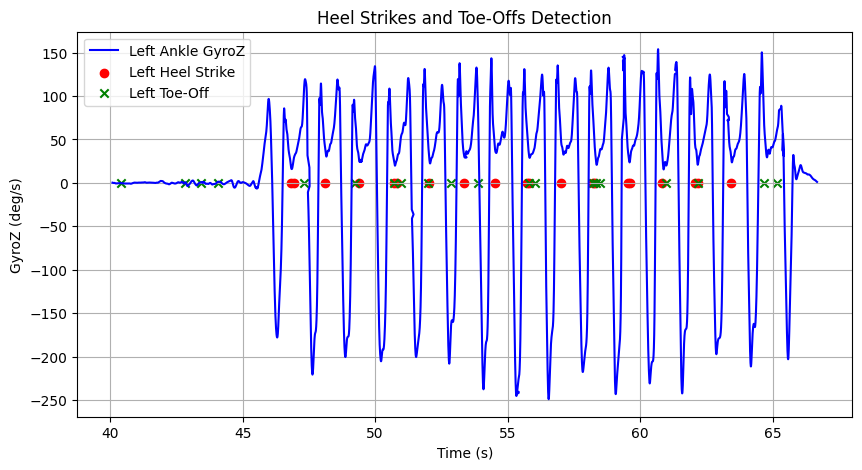

In [61]:
# -------------------------------
# Plot Heel Strikes & Toe-Offs
# -------------------------------
plt.figure(figsize=(10, 5))

# Plot GyroZ for left ankle
plt.plot(left_ankle_data["Time(s)"], left_ankle_data["GyroZ_filtered"], label="Left Ankle GyroZ", color='blue')
plt.scatter(left_heel_strikes, [0] * len(left_heel_strikes), marker='o', color='red', label="Left Heel Strike")
plt.scatter(left_toe_offs, [0] * len(left_toe_offs), marker='x', color='green', label="Left Toe-Off")

plt.xlabel("Time (s)")
plt.ylabel("GyroZ (deg/s)")
plt.legend()
plt.grid()
plt.title("Heel Strikes and Toe-Offs Detection")
plt.show(block=True)

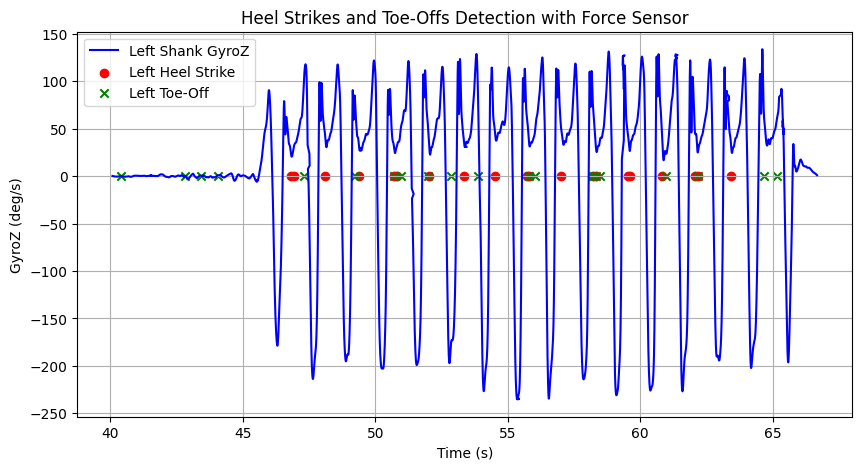

In [63]:
# -------------------------------
# Plot Heel Strikes & Toe-Offs
# -------------------------------
plt.figure(figsize=(10, 5))

# Plot GyroZ for left ankle
plt.plot(left_shank_data["Time(s)"], left_shank_data["GyroZ_filtered"], label="Left Shank GyroZ", color='blue')
plt.scatter(left_heel_strikes, [0] * len(left_heel_strikes), marker='o', color='red', label="Left Heel Strike")
plt.scatter(left_toe_offs, [0] * len(left_toe_offs), marker='x', color='green', label="Left Toe-Off")
# plt.plot(left_ankle_data["Time(s)"], left_ankle_data["GyroZ"], label="Left Ankle GyroZ", color='red')

plt.xlabel("Time (s)")
plt.ylabel("GyroZ (deg/s)")
plt.legend()
plt.grid()
plt.title("Heel Strikes and Toe-Offs Detection with Force Sensor")
plt.show(block=True)